In [1]:
import os
import glob
import random

import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

In [3]:
import mr

In [4]:
from mrcnn import model as modellib
from mrcnn import visualize

Using TensorFlow backend.


In [5]:
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [6]:
config = mr.TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        30
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [7]:
work_path = os.path.join("E:", os.sep, "RCNNPipes256Train")

os.chdir(work_path)

tif_glob = glob.glob(os.path.join("*", "images", "*.tif"))
n = int(len(tif_glob) * .8)

ds_train = mr.MRDataset()
ds_train.load_glob(tif_glob[:n])
ds_train.prepare()

ds_valid = mr.MRDataset()
ds_valid.load_glob(tif_glob[n:])
ds_valid.prepare()

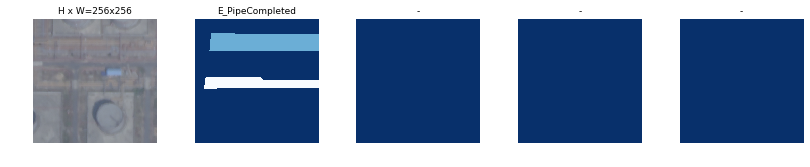

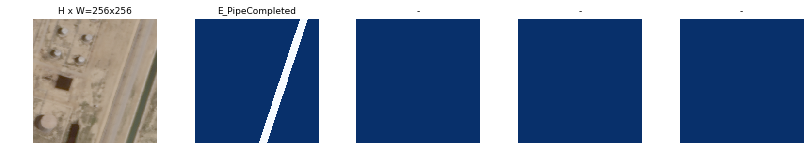

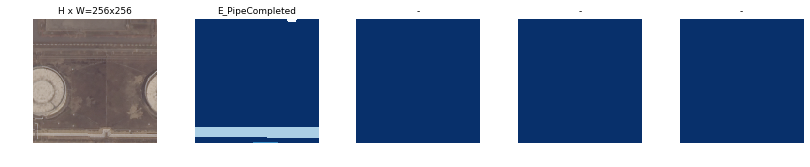

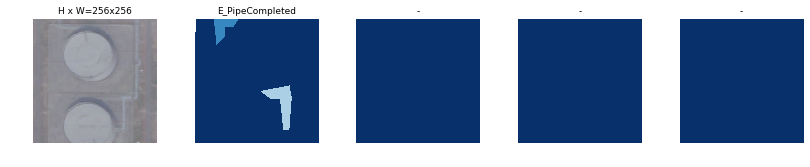

In [8]:
image_ids = np.random.choice(ds_train.image_ids,4)
for image_id in image_ids:
    image = ds_train.load_image(image_id)
    mask, class_ids = ds_train.load_mask(image_id)
    visualize.display_top_masks(image,mask,class_ids,ds_train.class_names)

In [9]:
model = modellib.MaskRCNN(mode="training",
                          config=config,
                          model_dir="logs")

In [10]:
# Which weights to start with?
init_with = "imagenet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(mr.COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits",
                                "mrcnn_bbox_fc", 
                                "mrcnn_bbox",
                                "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model_path = model.find_last()
    print("Loading weights from ", model_path)
    model.load_weights(model_path, by_name=True)

In [ ]:
model.train(ds_train, ds_valid, 
            learning_rate=config.LEARNING_RATE, 
            epochs=60, 
            layers='heads')


Starting at epoch 0. LR=0.0001

Checkpoint Path: logs\mr20190511T1144\mask_rcnn_mr_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed

C:\Users\raadm0\AppData\Local\ESRI\conda\envs\mask_rcnn\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
model.train(ds_train, ds_valid, 
            learning_rate=config.LEARNING_RATE,
            epochs=120, 
            layers="4+")

In [ ]:
model.train(ds_train, ds_valid, 
            learning_rate=config.LEARNING_RATE / 10.0,
            epochs=500, 
            layers="all")

In [ ]:
inference_config = mr.InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir="logs")

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
dataset = ds_valid
image_id = random.choice(dataset.image_ids)

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, inference_config, 
                           image_id, use_mini_mask=False)

results = model.detect([original_image], verbose=0)
r = results[0]

ax1, ax2 = get_ax(1,2)
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, ax=ax1)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax2)